# Empires and EDA
## Exploratory Data Analysis on Seshat's Axial Age Dataset

```
"90 of the data ever created was created in the last two years."
```

This [Petter Bae Brandtzæg](https://www.sciencedaily.com/releases/2013/05/130522085217.htm) quote, as frightening as it is, betrays an even more frightening observation: *We have ten times less data recorded in the past 2.8 million years of human history than we do about the years 2016-2018.* and given this estimated exponential growth rate of data since the dawn of the computer age, we have 10^15 *less* data recorded from the dawn of history to the fall of the Berlin Wall than we do for the past 30 years. If we look to before the invention of modern statistics in the mid-1600's, the ammount of data we can analyze is miniscule.  If we look to before the Domesday book in 1086, it gets downright depressing.

## Business Understanding
Luckily, nothing is restricting modern historians and academics from creating new data *about* the past. From digitized photos and text, documentation about archaeological digs, and even crowdsourced aggregations of academic consensus *about* historical periods, historians (and hobbyists like me) can create and explore datasets, using cutting-edge analytic tools to draw new understandings about the past, and helping answer questions like:

* What sociopolitical norms did different societies from across the Mediterranean and Asia develop over time in comparison with each other?
* Which of these norms were most and least likely to be observed in the same place and time?
* What are some of the distinct trajectories of related norms along which some groupings of societies but not others evolved?

## Data Understanding
For this analysis, I'm using the relatively small [Axial Age](http://seshatdatabank.info/datasets/) dataset by [Seshat](http://seshatdatabank.info/seshat-about-us/seshat-who-we-are/), "a large, international, multidisciplinary team of evolutionary scientists, historians, anthropologists, archaeologists, economists, and other social scientists." The publically available dataset tracks a variety of sociopolitical norms and their development across key areas in Afro-Eurasia to assess, and in their findings cast doubt upon, the theory that these cultural conditions let to the religious and philosophical renaissance known as the "axial age." The specific scores for each sociopolitical norm for each date (varying time spans between 5300 BCE and 1800 CE in 100 year increments) within 10 NGAs (natural geographic area) were agreed-upon by a group of experts and compiled into the dataset.

*This research employed data from the Seshat Databank (seshatdatabank.info) under Creative Commons Attribution Non-Commercial (CC By-NC SA) licensing.*

[Turchin P. et al. 2015. “Seshat: The Global History Databank.” Cliodynamics 6(1): 77–107](https://doi.org/10.21237/C7clio6127917)

[Mullins, D., Hoyer, D. et al. 2018. “A Systematic Assessment of ‘Axial Age’ Proposals Using Global Comparative Historical Evidence.” American Sociological Review 83(3): 596–626](https://doi.org/10.1177/0003122418772567)

### DS Process: Gather
First, I downloaded the dataset and created a [repository on GitHub](https://github.com/briantfriederich/Global_History). For later large visuals, I ran some javascript to prevent them prom printing in a scrollable window. After importing all the necessary packages, I read the CSV into pandas as `df`.

In [1277]:
# Prevent large visualizations from printing in a scroll window.

In [1278]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [1279]:
# Import all of the necessary packages.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.pyplot import stackplot
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline

In [1280]:
# Read in the data from CSV file.
df = pd.read_csv("data/axial_age.csv")

### DS Process: Assess
Printing the head of the dataframe, a couple problems immediately became apparent.  First, the name of `Date.From` would be problematic in Python due to the period within the name. Additionally, the feature names begin with a number and period, and contain spaces, which would also be problematic in Python and conducting clear analysis. Data for the Cambodian Basin appeared to begin with 200 CE, meaning data for the 5 1/2 centirues before then was missing, and some of the features carry `NaN` values.  All of this will need to be cleaned before conducting analysis and answering our questions. The features are coded in `float64` to allow for 0.5 values, and `NGA` is coded as an object.

In [1281]:
# Explore the dataframe.
df.head()

,Date.From,NGA,1. Moralistic punishment,2. Moralizing norms,3. Promotion of prosociality,4. Omniscient supernatural beings,5. Rulers not gods,6. Equating elites and commoners,7. Equating rulers and commoners,8. Formal legal code,9. General applicability of law,10. Constraint on executive,11. Full-time bureaucrats,12. Impeachment,sum
0,200,Cambodian Basin,0.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,7.0
1,300,Cambodian Basin,0.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,7.0
2,400,Cambodian Basin,0.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,7.0
3,500,Cambodian Basin,0.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,7.0
4,600,Cambodian Basin,0.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,6.0


In [1282]:
# Discern data types in the dataframe's columns.
df.dtypes

Date.From                              int64
NGA                                   object
1. Moralistic punishment             float64
2. Moralizing norms                  float64
3. Promotion of prosociality         float64
4. Omniscient supernatural beings    float64
5. Rulers not gods                   float64
6. Equating elites and commoners     float64
7. Equating rulers and commoners     float64
8. Formal legal code                 float64
9. General applicability of law      float64
10. Constraint on executive          float64
11. Full-time bureaucrats            float64
12. Impeachment                      float64
sum                                  float64
dtype: object

## Data Preparation
### DS Process: Clean
NaN values could have been a real problem for analysis, so I first printed the columns with no NaN values and then the columns with more than 1/3 NaN values to assess where I might need to ater or drop missing values. `Date.From` and `NGA` were both fully represented, as was `sum`, indicating `NaN` is only found in the features, and that `sum`, it turns out, represents the sum of features without the `NaN` values in a particual `NGA` at a particular time. Only two features were null in more than 1/3 of observations, indicating the dataset isn't so sparse as to be unusable. I also created a RegEx function for any proprocessing I may need to do in this analysis. I took out the numbers at the front of the feature names, replaced spaces and hyphens with underscores, and lowercased strings, in line with [PEP-8](https://www.python.org/dev/peps/pep-0008/). I then applied this function to the column headings and the columns `NGA`.

In [1283]:
# Print the names of the columns with no null values
# and with the most missing values.
no_nulls = set(df.columns[df.isnull().mean()==0])
print("Columns with no null values:\n{}".format(no_nulls))

most_missing_cols= set(df.columns[df.isnull().mean()>.3333])
print("\nColumns with most missing values:\n{}".format(most_missing_cols))

Columns with no null values:
{'11. Full-time bureaucrats', 'NGA', '8. Formal legal code', 'sum', 'Date.From'}

Columns with most missing values:
{'1. Moralistic punishment', '4. Omniscient supernatural beings'}


In [1284]:
# Create a text preprocessing function that removes numbers and periods, 
# replaces spaces and dashes with underscores, and lowercases letters
# for easier coding.


def text_preprocess(str):
    str = str.lstrip('0123456789. ')
    str = re.sub(r"\s+", '_', str)
    str = re.sub(r"[\-.]", '_', str)
    str = str.lower()
    return str


# Apply the text preprocessing tool to column names and the contents
# of the nga column.
df.columns = df.columns.to_series().apply(text_preprocess)
df["nga"] = df["nga"].map(text_preprocess)

# Check that the preprocessing worked.
print("RegExed Columns:\n" + str(df.columns))
print("\nRegExed NGAs:\n" + str(df.nga.unique()))

RegExed Columns:
Index(['date_from', 'nga', 'moralistic_punishment', 'moralizing_norms',
       'promotion_of_prosociality', 'omniscient_supernatural_beings',
       'rulers_not_gods', 'equating_elites_and_commoners',
       'equating_rulers_and_commoners', 'formal_legal_code',
       'general_applicability_of_law', 'constraint_on_executive',
       'full_time_bureaucrats', 'impeachment', 'sum'],
      dtype='object')

RegExed NGAs:
['cambodian_basin' 'crete' 'galilee' 'kachi_plain' 'kansai' 'konya_plain'
 'latium' 'middle_yellow_river_valley' 'susiana' 'upper_egypt']


I decided to replace the NaN values in the dataset with zero, as none of the columns were missing `nga` or `date_from`, and as this seems to be the convention within the dataset already for calculating the "sum" column.

In [1285]:
# Replace NaN values in the dataframe with 0.
df = df.fillna(0)

### DS Process: Further Analyzing and Cleaning (The "date_from" Problem)
I confirmed my earlier suspicion that not all NGAs are represented for all time periods. This skewedness in seen in both the summary statistics and histogram below. The distribution of dates indicated that NGAs began to be represented at varying starting times and tended to continue to be observed until about 1800. Breaking this down by `nga` with the `groupby` function, this suspicion is confirmed with starting years ranging from 5300 BCE to 200 CE and four NGAs ceasings observations in 1600 or 1700.

In [1286]:
# Check the summary statistics of the date_from column.
df_subset=df["date_from"]
df_subset.describe()

count     428.000000
mean     -636.448598
std      1665.486125
min     -5300.000000
25%     -1700.000000
50%      -400.000000
75%       700.000000
max      1800.000000
Name: date_from, dtype: float64

Text(0.5,0,'Years CE')

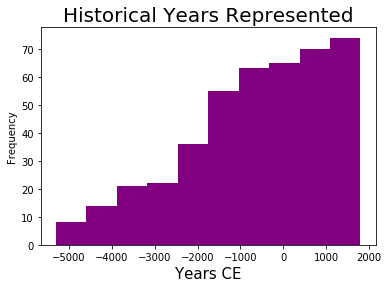

In [1291]:
# Plot the distribution of date_from column.
df.date_from.plot(kind="hist", color = 'purple');
plt.title("Historical Years Represented", fontsize = 20)
plt.xlabel("Years CE", fontsize = 15)

In [1292]:
# Explore the distribution of date_from entries by nga.
df.groupby(["nga"]).describe()['date_from']

,count,mean,std,min,25%,50%,75%,max
nga,,,,,,,,
cambodian_basin,17.0,1000.0,504.975247,200.0,600.0,1000.0,1400.0,1800.0
crete,38.0,-50.0,1111.305539,-1900.0,-975.0,-50.0,875.0,1800.0
galilee,34.0,50.0,995.824616,-1600.0,-775.0,50.0,875.0,1700.0
kachi_plain,43.0,-400.0,1255.653880,-2500.0,-1450.0,-400.0,650.0,1700.0
kansai,70.0,-1850.0,2035.108515,-5300.0,-3575.0,-1850.0,-125.0,1600.0
konya_plain,39.0,-100.0,1140.175425,-2000.0,-1050.0,-100.0,850.0,1800.0
latium,27.0,300.0,793.725393,-1000.0,-350.0,300.0,950.0,1600.0
middle_yellow_river_valley,39.0,-100.0,1140.175425,-2000.0,-1050.0,-100.0,850.0,1800.0
susiana,58.0,-1050.0,1688.687854,-3900.0,-2475.0,-1050.0,375.0,1800.0


To plot this more intuitively, I created a dictionary and then dataframe using a `for` loop and put the results on an `hline`, color coding each `nga` in a color scheme I used throught this analysis (purple is used for agregates across NGAs).

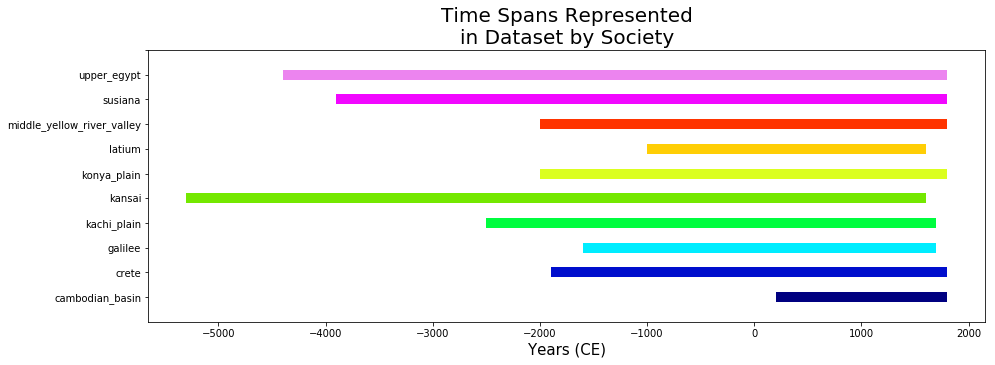

In [1293]:
# Prepare to plot time spans for each nga.

# Create lists of unique ngas and dates.
nga_list = df.nga.unique()
df_date_list = df.date_from.unique()
df_date_list = sorted(df_date_list)

# Set preliminary variables to be used in creating
# a dataframe dictionary for the plot.
timespans=[]
y_placement = 0
# Set colors to be used for each nga throughout analysis.
colormap = plt.cm.gist_ncar
colorst = [colormap(i) for i in np.linspace(0, 0.9, 10)]

# Create a dataframe for plot.
for place in nga_list:
    new_dict = {}
    subset = df[df["nga"] == place]
    new_dict['nga'] = place
    new_dict['y_placement'] = y_placement
    new_dict['time_start'] = min(subset["date_from"])
    new_dict['time_end'] = max(subset["date_from"])
    new_dict['color'] = colorst[y_placement]
    y_placement += 1
    timespans.append(new_dict)
timedf =pd.DataFrame(timespans)

# Plot time spans by nga.
plt.figure(figsize=(15,5))
plt.hlines(timedf.y_placement, timedf.time_start, 
           timedf.time_end, lw = 10, color = timedf.color)
plt.ylim(-1, len(timedf))
plt.yticks(range(len(timedf)+1), timedf.nga)
plt.title("Time Spans Represented\nin Dataset by Society", 
          fontsize = 20)
plt.xlabel("Years (CE)", fontsize = 15)
plt.show()

### DS Process: Analyze
I wanted to plot the sum column for each NGA over time to assess overall trends. In general, it seems scolars agreed that NGAs tended to accumulate relevant cultural features over time in a general upward trend. A clear exception is the Cambodian Basin, which experienced a notable dip in its sum from about 600 CE to 1200 CE, roughly overlapping with the Chenla and High Angkor Periods (the decline trend bottoming out and then rebounding during the early Angkor Period). Kansai has a very long period of all zero observations, which with a quick look at the original CSV is confirmed to be largely NaN observations, until about 300 BCE, the traditional dating for the beginning of the Yaoyi Period, and when a proliferation of material culture begins to give better clues to early Japanese history. It's unclear why Seshat chose to include the long period of zeroes and NaN values.

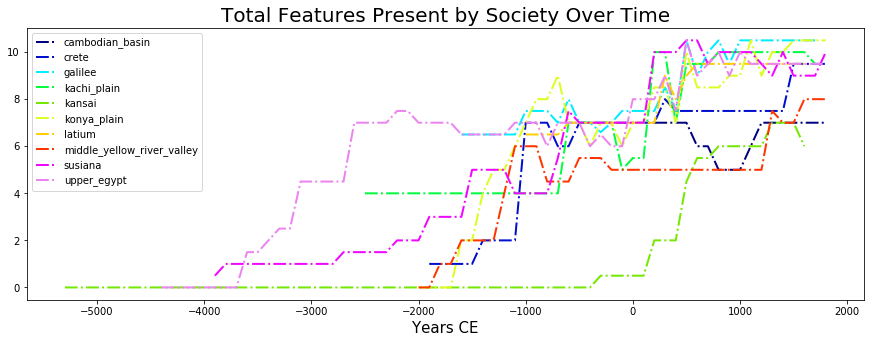

In [1296]:
# Plot the sum column over time, grouped by nga.
ckey = 0
plt.figure(figsize=(15,5))
for i in nga_list:
    subset = df[df["nga"] == i]
    plt.plot(subset['date_from'],
                    subset['sum'],
                    lw=2, 
             color = colorst[ckey], linestyle = "-.")
    plt.legend(nga_list)
    ckey += 1
plt.title("Total Features Present by Society Over Time", 
          fontsize = 20)
plt.xlabel("Years CE", fontsize = 15)
plt.show()

I then chose to plot the total of sums across NGAs and over time. I noted that from 5300 BCE to 4000 BCE, there were zero positive cultural feature observations. The general cumulative trend elsewhere was generally positive, save a flat period from about 1000 BCE to 100 CE, roughly corresponding to the Iron Age and Classical Antiquity in the Mediterranean, where half of the NGAs are located. There is also a notable dip around 400 CE around the collapse of the Western Roman Empire, and sharp decline after 1600 CE, though that could be due to observations for some NGAs ceasing around this period.

<Figure size 432x288 with 0 Axes>

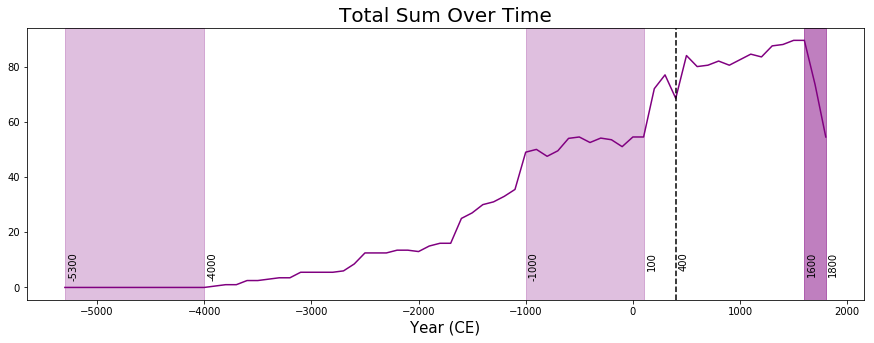

In [1297]:
# Plot the total sum of the sum column across ngas over years.

# Group the sums by date_from.
total_sum = df.groupby(["date_from"]).sum()
total_sum = total_sum[["sum"]]

# Plot the figure.
plt.figure()
total_sum.plot(color = 'purple', legend = False, figsize = (15, 5))
plt.xlabel("Year (CE)", fontsize = 15)
plt.title("Total Sum Over Time", fontsize = 20)

# Add shading and date lables for important dates and date ranges
# observed in the plot.
plt.text(-5270,10,'-5300',rotation=90)
plt.text(-3970,10,'-4000',rotation=90)
plt.text(-970,10,'-1000',rotation=90)
plt.text(130,10,'100',rotation=90)
plt.axvline(400, color='k', linestyle='--')
plt.text(430,10,'400',rotation=90)
plt.text(1620,10,'1600',rotation=90)
plt.text(1820,10,'1800',rotation=90)
plt.axvspan(-5300, -4000, alpha=0.25, color='purple')
plt.axvspan(-1000, 100, alpha=0.25, color='purple')
plt.axvspan(1600, 1800, alpha=0.5, color='purple')

We continue to observe this general upward trend over time for most features when we plot each feature's cumulative sum across NGAs over time. The trends are a lot less smooth, though, probably reflecting specific changes in specific NGAs. The three most notable exceptions are `impeachment` and `moralistic_punishment`, which quickly come into and fall out of fashion, and `omniscient_supernatural_beings`, which spikes then quickly drops around year 1 before bouncing back to an even higher level. These swings could provide us with good natural experiments for assessing the relationships between features.

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


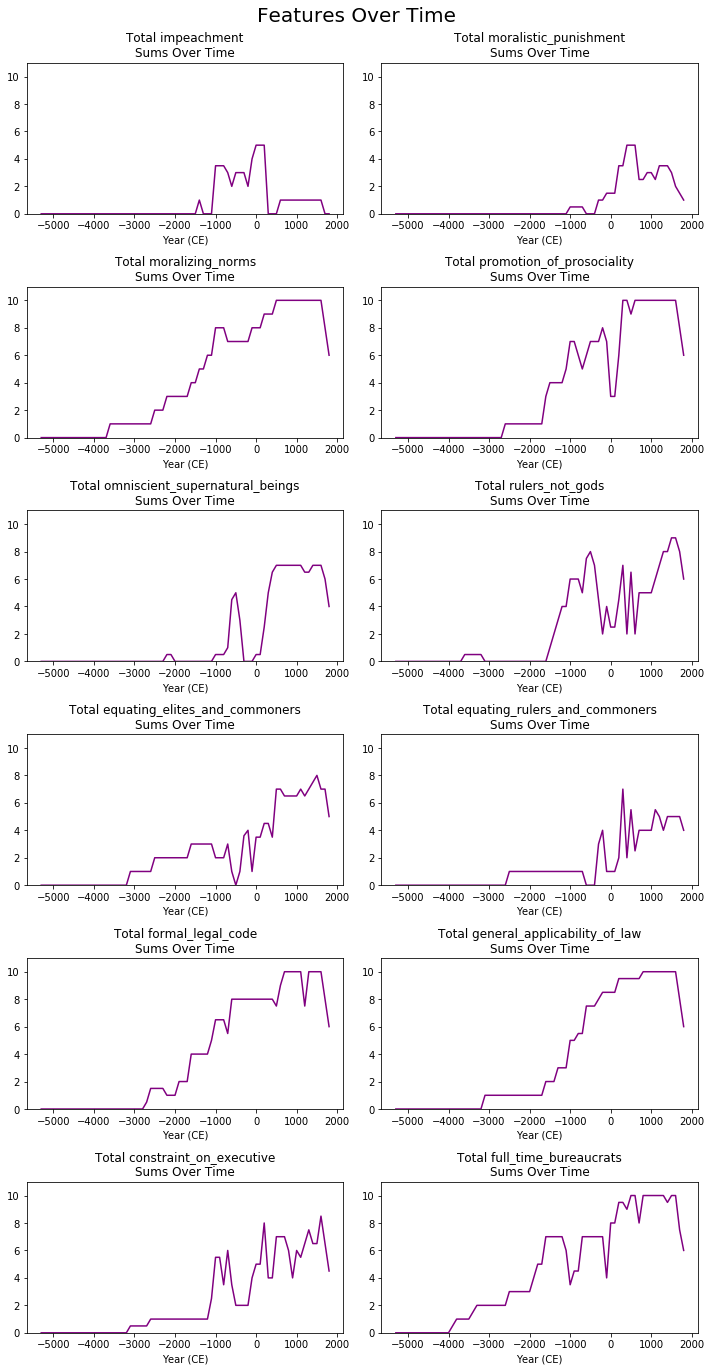

In [1299]:
# Plot total observations by feature over time.

# Create a list of non-time, non-geographic, and non-aggregate
# features in the dataset.
col_list = (list(df))
new_col_list = (col_list[2:-1])

# Create a dataframe for the plot.
feature_adoption=[]
for i in df_date_list:
    date_dict = {}
    date_dict["year"] = i
    df_years = df.loc[df['date_from'] == i]
    for j in new_col_list:
        df_feature = df_years[["date_from", j]]
        total = df_feature[j].sum()
        date_dict[j] = total
    feature_adoption.append(date_dict)    
adoptiondf = pd.DataFrame(feature_adoption)

# Plot subplots of features over time.    
fig = plt.figure(figsize=(10,20))
num = 1
for i in range(12):
    ax = fig.add_subplot(6,2,num)
    adoptiondf.plot(x='year', y=new_col_list[i-1], 
                    ax = ax, legend = False, color = "purple")
    plt.title("Total {}\nSums Over Time".format(new_col_list[i-1]))
    ax.set_xlabel("Year (CE)")
    plt.ylim(0, 11)
    num += 1  

# Set plat superparameters. 
fig.suptitle("Features Over Time", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.show()

Breaking this down even further into stackplots over time for each NGA gives interesting insights into local history. In addition to earlier observations on the Cambodian Basin, we can see the emergence and quick decline of relative social equality (equating rulers, elites, and commoners) during the chaotic reign of Suryavarman I, as well as a return of the idea that rulers are not gods with Angkor's Golden Age, the rise and fall of moralistic punishment during the Angkor Period, and constraints on the executive reappearing once the Angkor Empire waned.

In Crete, interestingly, we see the largest leap in developing relevant cultural features with the end of the Minoan and Mycenean Periods in the Bronze Age Collapse. This remained fairly steady throughout Greek Antiquity, notable for the normalization of impeachment, constraints on the executive, and promotion of prosociality, until the arrival of the Romans, which saw the introduction of equating elites and commoners, to a small degree. The rise of the Eastern Roman or Byzantine Empire corresponded with a short-lived relative equation between rulers and commoners, the promotionof rulers as gods, the rise of a belief in omniscient supernatural beings, and the introduction of moralistic punishment, all hallmarks of theocratic tendencies within the Orthodox Christian Byzantine Empire and later Catholic Ventian Empire. The Divine Right of Kings and the extremes of societal inequality between rulers and commoners both declined with the Renaissance.

A quick look at Galilee's stackplot reveals a tumultuous history, with Galilean cultural norms likely following the norms of Babylonian, Persian, local Jewish, Hellenistic, Roman, and Byzantine rule, and finally stabilizing under the Arab Caliphate in 638. Despite the crusades, the presence of these norms remains remarcably constant compared to earlier periods through the end of observations in 1700.

The first major changes in the Kachi Plain in modern Pakistan came around 700 BCE with the emergence of a belief in omniscient supernatural beings the belief that rulers are not gods, and generalized, formal law under the influence of the Persian Achaemenid Empire. The belief in omniscient supernatural beings waned and a relative equation of rules, elites, and commoners came with Greek and Muryan rule. We then see a spike in total observed features under the Paratarajas, especially under the orbit of the Sasanian Empire, particularly with the introduction of moralistic punishment, the emergence of the idea that rulers were not gods, could be more constrained as executives, and in fact, were regarded as more equal in some respects to commoners than they had been earlier. After a dip in some norms under the Sassanians, total bounced back under the Rai and Brahman Dynasties and had recovered previous levels by the arrival of Islam in the area.

In Kansai, we see rapid development of relevant features during the Kofun Period from 300 CE to 538 CE. These norms seem firmly established by the Nara period in 710 CE. Later we see the emergence of constraints on the executive following the end of the Kenmu Restoration.

The Konya Plain, like Galilee, shows a level of cultural turmoil due to repeated conquest from Greek colonization around 500 BCE to about 600 CE in the wake of Justinian II as the Byzantine Empire consolidated control of the area. A pair of notable late developments are the cessation of the belief that rulers are gods and a relative equation of rulers and commoners beginning around 1000 CE when the Seljuk Turks wrested control of the region from the semi-theocratic Byzantine Empire.

Latium, or the area of Rome, has four semi-distinct periods, with the promotion of prosociality disappearing during the height of its imperial era, replaced by the emergence of a bureaucracy and a relative equation of elites and commoners. As the empire waned, impeachment disappeared through some equation between elites and commoners persisted and was joined by some equation of rulers and commoners, along with moralistic punishment and the belief in omniscient supernatural beings with Emperor Constantine's conversion to Christianity. By the time of Charlemagne and the establishment of the Holy Roman Empire, notions of relative equality between rulers, elites, and commoners had disappeared and Latium had settled into the mix of relevant cultural features that defined it until the end of observations at around 1600.

In China, relevant features begin developing in the Xia Dynasty, but really take off during the Shang Dynasty from 1600 BCE to 1050 BCE, with the emergence of moralizing norms, the belief that rulers are not gods, a formal legal code, and constraints on the executive, all features, with the exception of the latter, that would much later be codified in the philosophy of Confucianism. Constraints on the executive and the promotion of prosociality ceased, but a generla aplicability fo law flourished during the Spring and Autumn and Warring States periods, with impeachment a notable unique attribute of the Warring States Period. Impeachment was out and the promotion of prosociality and divinity of rulers were back in with Emperor Qin Shi Huang Di's consolidation of the Chinese Empire in a mix of relevant cultural features that would hold steady until the Southern Song Dynasty began in 1127. Over the Southern Song Dynasty, constraints on the executive reemerged along with the beliefs that rulers were not gods and elites and commoners were equal in some regards, perhaps giving rise to the traditional respect for farmers as the feeders of the empire. Constraints on the executive faded again under Mongol control in the Yuan Dynasty, but reemerged with the Ming Dynasty.

Various relevant features developed over the Elamite Period in Susiana from around 2700 BCE to 539 BCE. The Achaemenid Dynasty, established in 550 BCE, saw the reemergence of the bureaucracy after a waning in the late Elamite period, constraints on the executive, a general aplicability of law, and a belief in omniscient supernatural beings under Zoroastrianism. Under the Post-Hellenistic Parthians, this belief waned but was replaced with relative equality of rulers and elites with commoners. The Muslim Sassanians brought back the belief in an omniscient supernatural being along with moralistic punishment influenced by sharia and a difinitive belief that rulers are not gods and can be constrained institutionally. Susiana's mix of relevant cultural features did not change much after the Sassanians, despite being conquered by the Islamic Caliphate and later the Mongols, with the biggest difference being the waning of moralistic punishment.

Ancient Egypt has always been notable for its stability, with continuation prozed over innovation well into the Hellenistic Period. Relevant features remained fairly constant from their emergence to the arrival of Persian conquerors in 525 BCE, at which point rulers were less likely to be considered divine, but also less constrained. Relative equality between elites and commoners disappeared and moralistic punishment emerged under Helenistic rule, and later, the promotion of prosociality was replaced by the possibility of impeachment and constraints on the executive under Western Roman rule. Prosociality came back, along with constraints on the executive and the equation of rulers and commoners and a belief in an omniscient supernatural being under Eastern Roman and then Arab Caliphate rule, with the later doing away with moralistic punishment.

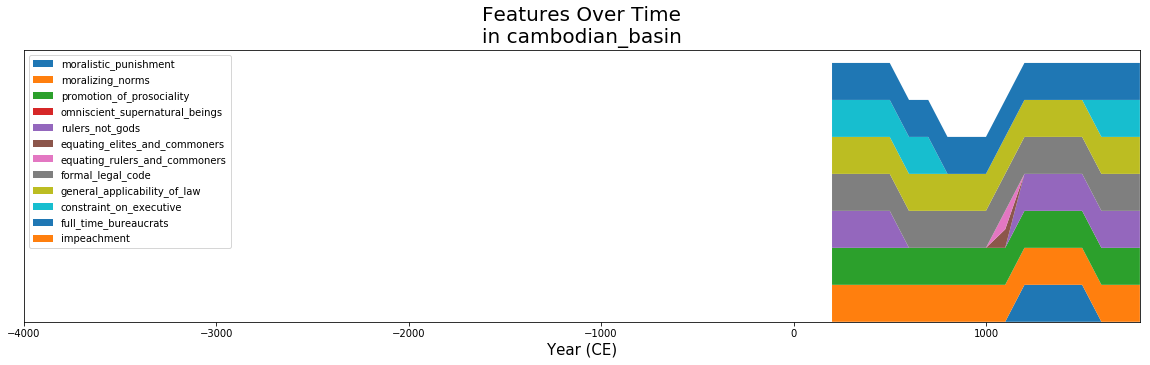

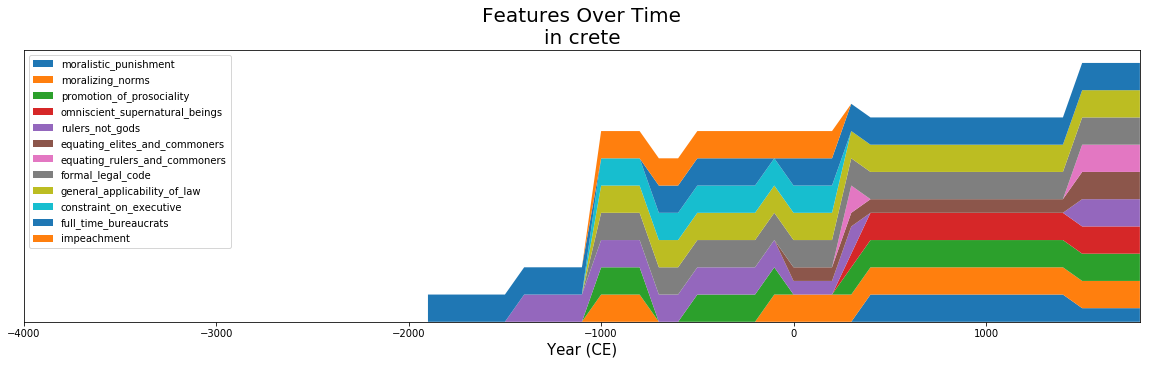

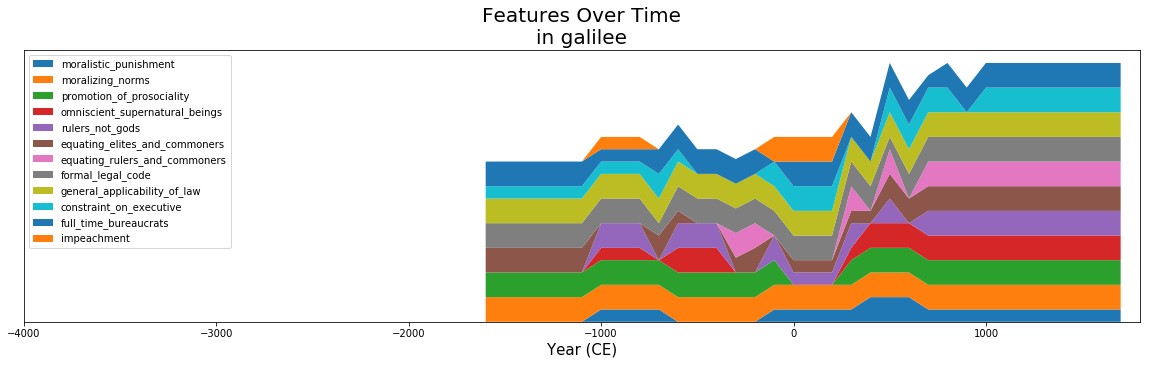

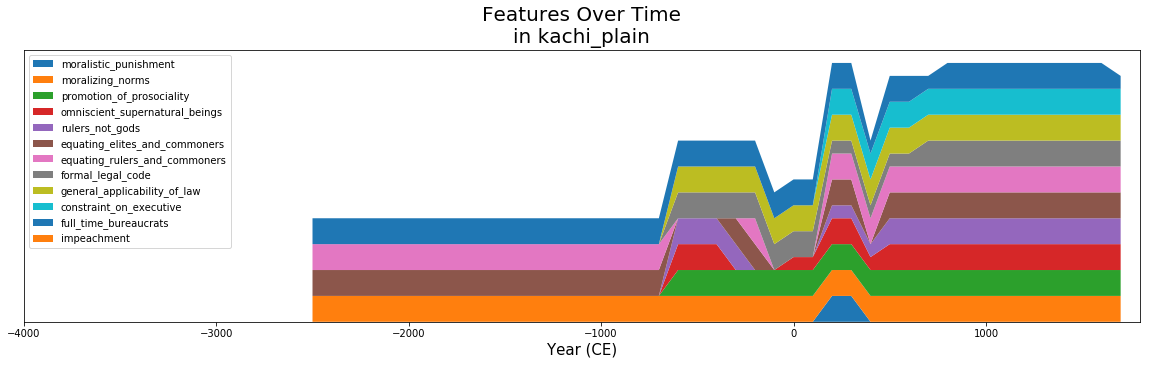

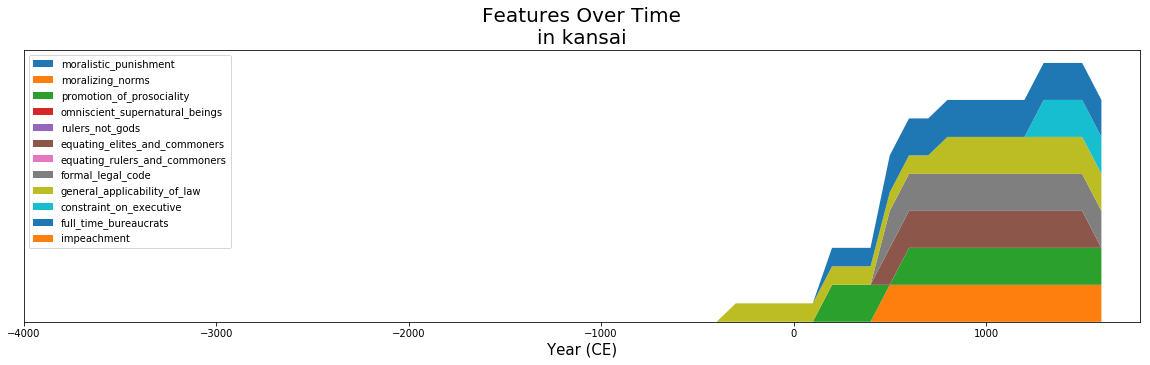

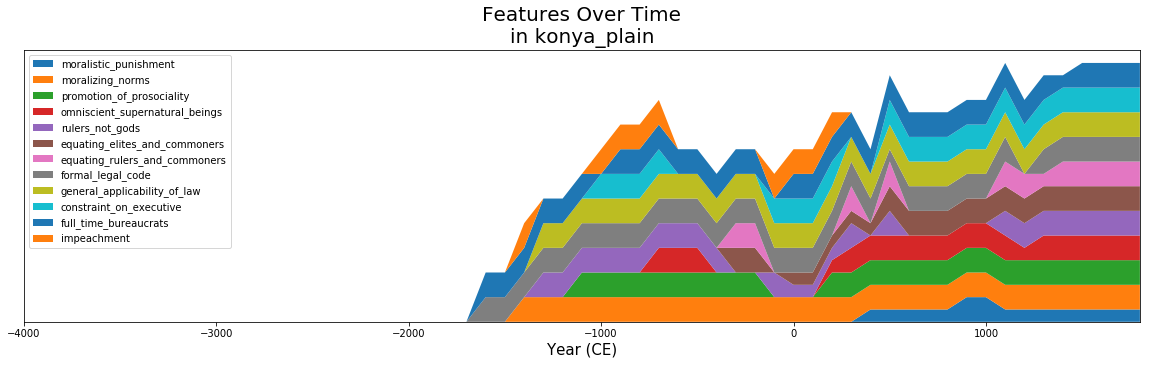

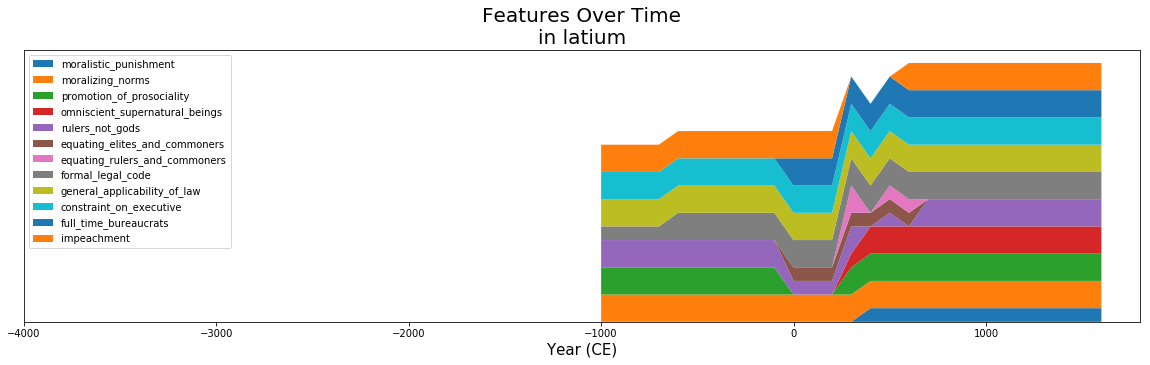

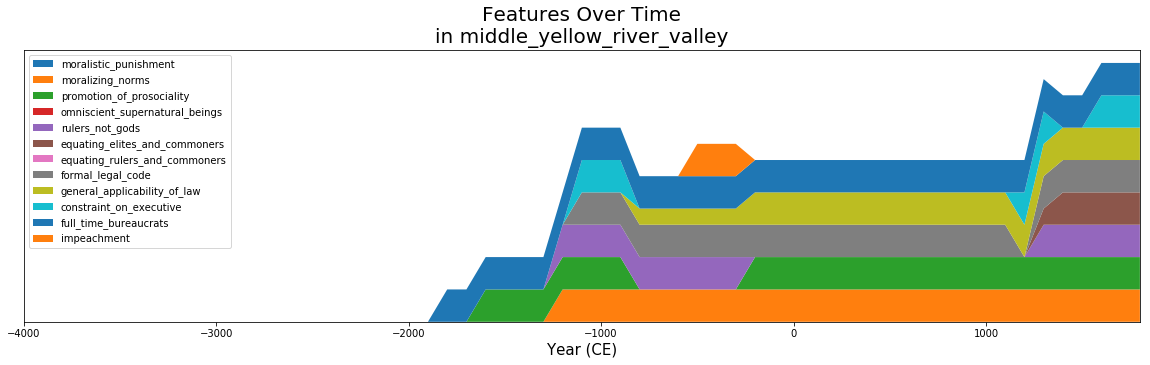

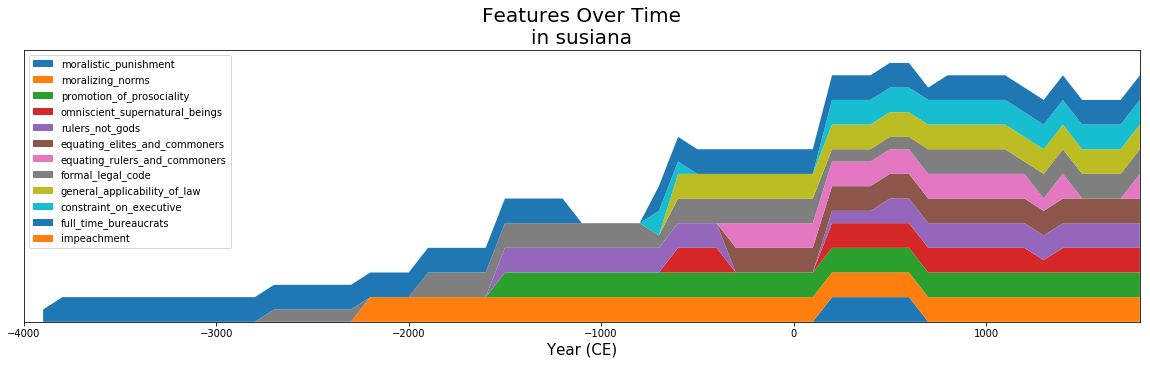

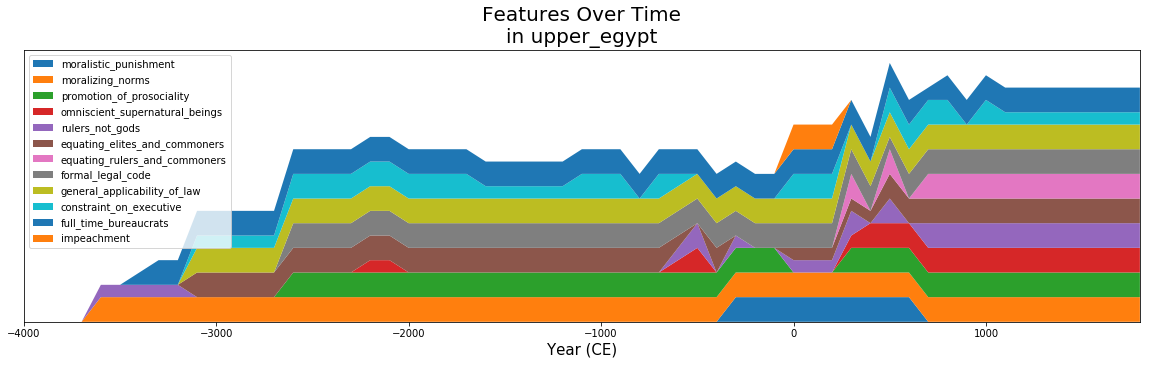

In [1300]:
# Plot stackplots of features within each nga over time.
for i in nga_list:
    nga_subdf = df[df['nga'] == i]
    nga_subdf = nga_subdf.drop(['nga', 'sum'], axis = 1)
    fig, ax = plt.subplots(figsize=(20,5))
    ax.stackplot(nga_subdf['date_from'], 
                 nga_subdf['moralistic_punishment'], 
                 nga_subdf['moralizing_norms'], 
                 nga_subdf['promotion_of_prosociality'], 
                 nga_subdf['omniscient_supernatural_beings'],
                 nga_subdf['rulers_not_gods'], 
                 nga_subdf['equating_elites_and_commoners'],
                 nga_subdf['equating_rulers_and_commoners'],
                 nga_subdf['formal_legal_code'],
                 nga_subdf['general_applicability_of_law'],
                 nga_subdf['constraint_on_executive'],
                 nga_subdf['full_time_bureaucrats'],
                 nga_subdf['impeachment'], 
                 labels = new_col_list)
    ax.set_xlim(-4000, 1800)
    ax.set_title("Features Over Time\nin {}".format(i),
                 fontsize = 20)
    ax.set_xlabel("Year (CE)", fontsize = 15)
    ax.legend(loc=2)
    ax.axes.get_yaxis().set_visible(False)

### Question 1: *What sociopolitical norms did different societies from across the Mediterranean and Asia develop over time in comparison with each other?*
To answer this question, I first had to create total sums and averages of features over time within each NGA. The mean values ended up more insightful due to the different lengths of time observed for each NGA. With the exception of Cambodia and the Kachi Plain repectively, moralistic punishment and the belief in omniscient supernatural beings was a strong feature throught the Classical world but not in Southern and Eastern Asian societies. Moralizing norms, and to a lesser extent, promotion of prosociality, the belief that rulers were not gods, a formal legal code, general applicability of law, constraints on the executive, and full time bureaucrats were features common to all NGAs except Kansai, perhaps due to the high value of null values for that NGA. Galilee, the Kachi Plain, the Konya Plain, Susiana, Upper Egypt, and to a lesser extent Crete, all of which with the excpetion of Crete fell under Islamic rule by the modern period, scored markedly higher on equating rulers and commoners with elites. Constraints on the executive and impeachment appear to be noticeably Roman traits, with Latium leading the pack by a long shot, followed by the former Roman-ruled areas of Crete, Galilee, Upper Egypt, and the Konya Plain, though the Yellow River Valley did have a marginally greater instance of impeachment than Upper Egypt. This is flipped in terms of full-time bureaucrats.  With the excpetion fo Kansai for resons mentioned earlier, every NGA exhibits a much greater instance of full-time bureaucrats than Latium.

In [1301]:
# Calculate the sum of each feature over time within each nga.
nga_sum = df.groupby(["nga"]).sum()
nga_sum = nga_sum.drop('date_from', axis = 1)

# Calculate the mean of each feature over time with each nga.
nga_mean = df.groupby(["nga"]).mean()
nga_mean = nga_mean.drop('date_from', axis = 1)

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


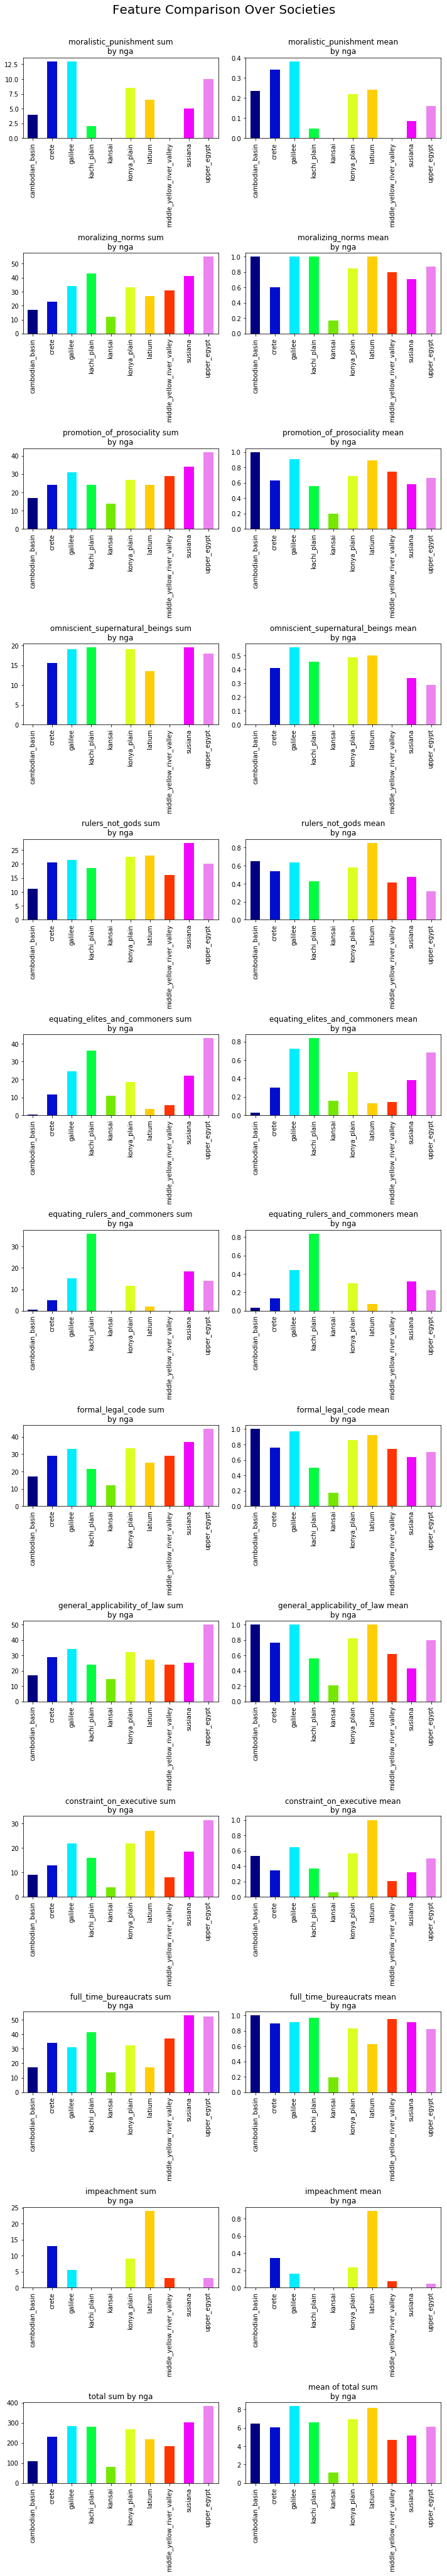

In [1302]:
# Plot comparative sums and means of features by nga over time.

# Plot comparative sums.
fig = plt.figure(figsize=(10,60))
num = 1
for i in nga_sum:
    subdf = nga_sum[[i]]
    ax = fig.add_subplot(13,2,num)
    if i != 'sum':
        subdf.plot.bar(ax = ax, legend = False,
                       title = "{} sum\nby nga".format(i),
                       color = [colorst])
    else:
        subdf.plot.bar(ax = ax, legend = False,
                       title = "total sum by nga",
                       color = [colorst])
    ax.xaxis.label.set_visible(False)
    num += 2

# Plot comparative means.    
num = 2
for i in nga_mean:
    subdf = nga_mean[[i]]
    ax = fig.add_subplot(13,2,num)
    if i != 'sum':
        subdf.plot.bar(ax = ax, legend = False,
                       title = "{} mean\nby nga".format(i),
                       color = [colorst])
    else:
        subdf.plot.bar(ax = ax, legend = False,
                       title = "mean of total sum\nby nga",
                       color = [colorst])
    ax.xaxis.label.set_visible(False)
    num += 2    

# Add the plot superparameters.
fig.suptitle("Feature Comparison Over Societies", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.show()

To overcome problems caused by null values, as in the case of Kansai, I also plotted a relative profile across relevant features for each NGA. Transposing the martix from my previous graphs made this easy, though color-coding each NGA's plot accordingly proved a minor challenge.

The Cambodian Basin was characterized over time by promoting the group over the self and a formalized, generally applied law structure within which an advanced bureaucracy operated. Inequality seems to have been high, with limited checks on power structures.

Crete was similarly characterized by comprehensive and formalized laws, though individual good was more highly promoted than in Cambodia. There was a great discrepancy in the perceived value of rulers and commoners, though rulers could in some instanced be removed. There was also some belief at some times in an omniscient god.

Galilee once again had a highly structured legal framework, generally applied and bureaucratized, but with a much greater emphasis on the group good and moralistic punishment. Equality was more highly promoted, executives were more constrained, and rulers were less liekly to be considered gods, as belief in an omniscient supernatural being was widespread. Still, rulerws could rarely be removed through institutional means once in power.

On the Kachi Plain, society was relatively unlikely to punish you for moral rather than legal reasons, though the pressure to stick by societal moral norms was extremely high. Rulers, elites, and commoners had remarkably equal inherant value in the eyes of society, though laws were a little fungible.

In Kansai, social pressure to fit in was high, which along with a formalized and generally-applied legal code and a strong bureaucracy likely meant people generally knew what was expected of them within society. Although elites and commoners were relatively equal, the ruler was God.

The Konya Plain's profile was much like Galilee, with some rule of law, emphasis on the group good, moderate equality, a constrained executive, and a belief that rulers were not god along with a blief in an Omniscient supernatural being. However, moralistic punishment was less common than in Galilee.

Latium epitomized rule of law, with formal legal codes favored over moralistic punishment, constraints on the executive, and even a strong tradition on impeachment. Rulers were not god, and there was widespread belief in an omniscient supernatural being. However, inequality was rampant, with commoners generally not considered as valuable as elites or rulers by society.

Like Cambodia and Kansai, the Middle Yellow River Valley exemplified a mix of prosocial norms, a strong legal framework, and a bureaucracy. However, rulers were often not considered divine and could at times be constrained institutionally. Social stratification may have also been higher in the Yellow River Valley than in Kansai as elites were less equated with commoners.

Although Susiana had strong prosocial and moral norms, a formal legal code, and a army of bureaucrats, laws appear to have been less generally applied. Executives were moderately constrained and social stratification was relatively low.

In Egypt, moralizing norms were of high importance, though a formalized and general legal framework existed. There was. astrong bureaucracy and equality between elites and commoners was relatively high. Although rulers were at times considered divine, they could be highly institutionally constrained.

In [1303]:
# Transpose the nga_mean dataframe to plot mean 
# feature values observed within ngas.
nga_mean_transposed = nga_mean.drop('sum', axis = 1)
nga_mean_transposed = nga_mean_transposed.transpose()

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


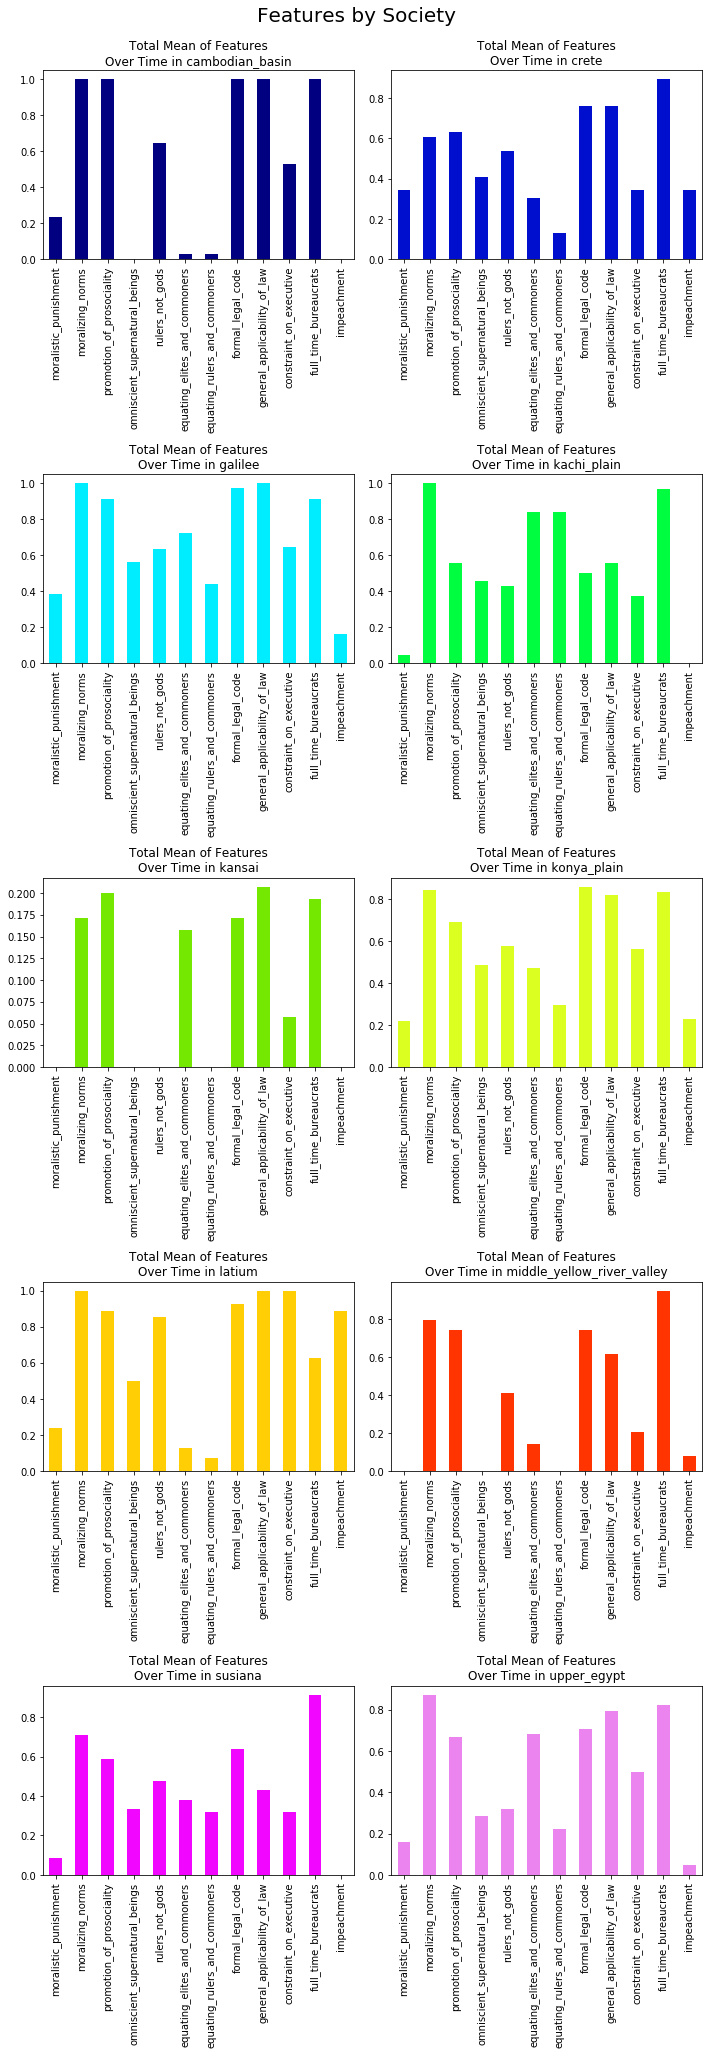

In [1304]:
# Plot mean values for each feature observed in a given nga.
fig = plt.figure(figsize=(10,30))
num = 1
color_idx = 0
for i in nga_mean2:
    color = colorst[color_idx]
    subdf = nga_mean2[[i]]
    ax = fig.add_subplot(5,2,num)
    subdf.plot.bar(ax = ax, legend = False,
                   title = "Total Mean of Features\nOver Time in {}".format(i),
                   color = color)
    color_idx += 1
    num += 1

# Set the figure superparameters.
fig.suptitle("Features by Society", fontsize = 20)
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.show()

## Modeling
### DS Process: Model and Visualize
Due to limited observations and degrees of freedom, many variables, the pseudo-binary nature of the dataset, and differing time ranges for observations, a lot of traditional modeling is rendered impractical. Instead, I chose to use correlation and principal component analysis to answer the last two questions and continue to emplore the dataset.

### Question 2: *Which of these norms were most and least likely to be observed in the same place and time?*
To answer this question, I made a correlation matrix of the relevant features. As could be expected from a dataset where features tende3d to accumulate over time, correlations skew positive. 

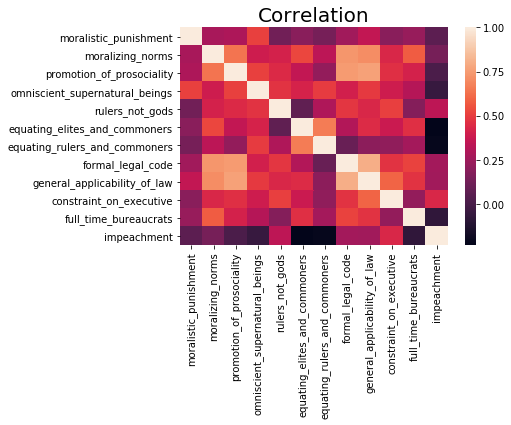

In [1305]:
# Separate out features from the dataframe and run a correlation matrix.
features_df = df.iloc[:,1:14]
corr = features_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

s = corr.unstack()
so = s.sort_values()
plt.title("Correlation", fontsize = 20)
plt.show()

Quantitatively, a formal legal code, promotion of prosociality, and a general applicability of law were most likely to be observed together, with a strong positive relationship in the data. A formal legal code, generally applied, can be thought of as a promotion of prosociality and an incentive to "play by the rules." Impeachment was the least likely feature to co-occur with equating elites and commoners and equating rulers and commoners, each with a mild negative relationship. Impeachment also correlated negatively, though much more weakly, with the presence of full-time bureaucrats. It seems a strong bureaucracy and relative social equality may have removed some of the need to constrain an executive who was far from all-powerful and needed legitimacy and cooperation from others in order to rule. The least-correlated features were impeachment and an omniscient supernatural being, the promotion of prosociality, and moralistic punishment, meaning the latter three did not really correlate with the presence or absence of the former in any meaningful way.

In [1306]:
# Print the three strongest negative and positive correlations
# and the three weakest correlations.
print("Three strongest negative correlations:")
print(so.iloc[[1,3,5]])
print("\nThree strongest positive correlations:")
print(so.iloc[[-13, -15, -18]])
print("\nThree weakest correlations:")
print(so.iloc[[7, 9, 11]])

Three strongest negative correlations:
impeachment                    equating_elites_and_commoners   -0.231705
equating_rulers_and_commoners  impeachment                     -0.216407
impeachment                    full_time_bureaucrats           -0.073451
dtype: float64

Three strongest positive correlations:
formal_legal_code          general_applicability_of_law    0.807245
promotion_of_prosociality  general_applicability_of_law    0.768953
formal_legal_code          promotion_of_prosociality       0.745948
dtype: float64

Three weakest correlations:
omniscient_supernatural_beings  impeachment                 -0.053097
impeachment                     promotion_of_prosociality    0.010875
moralistic_punishment           impeachment                  0.065528
dtype: float64


### Question 3: *What are some of the distinct trajectories of related norms along which some groupings of societies but not others evolved?*
To answer this question, I first wanted to check whether the skwedness of the dataset towards Mediterranean NGAs or the unique time periods observed in the plot of the total sum of sums over time could correlate with the presence or absence of features. To do this, I encoded dummy variables for mediterranean countries as well as the relatively flat date range of 1000 BCE to 100 CE, and the marked dip in the total sum around 400 CE.

In [1307]:
# Drop the sum and nga columns ahead of PCA and add testing features
# for reasonable groupings based on earlier observations.
mediterr_list = ['crete', 'galilee', 'latium', 'upper_egypt', 'konya_plain']
df = df.drop(['sum'], axis=1)
df["mediterranean"] = np.where(df['nga'].isin(mediterr_list),
                               1.0, 0.0)
df['classical_antiquity'] = np.where(np.logical_and(df['date_from'] > -1000, 
                                                    df['date_from'] <= 100), 1.0, 0.0)
df["fall_of_rome"] = np.where(df['date_from'] == 400, 1.0, 0.0)
df = df.drop(['nga'], axis = 1)
df.columns

Index(['date_from', 'moralistic_punishment', 'moralizing_norms',
       'promotion_of_prosociality', 'omniscient_supernatural_beings',
       'rulers_not_gods', 'equating_elites_and_commoners',
       'equating_rulers_and_commoners', 'formal_legal_code',
       'general_applicability_of_law', 'constraint_on_executive',
       'full_time_bureaucrats', 'impeachment', 'mediterranean',
       'classical_antiquity', 'fall_of_rome'],
      dtype='object')

Correlating these dummay variables plus the `date_from` variable (otherwise `date_from` would correlate perfectly with `classical_antiquity` and `fall_of_rome`), I saw that none of these correlated significantly with the presence or absence of other variables. I could proceed with principal component analysis (PCA) with the dataset as is.

In [1308]:
# Test the correlations of testing features and year with the dataset.

# Create a list of testing features.
cortest_variables = ['date_from','mediterranean',
       'classical_antiquity', 'fall_of_rome']

# Drop the testing features from the dataset.
new_data = df.drop(cortest_variables, axis = 1)

# Run a decision tree regressor and print the correlation
# and confidence interval of the testing variables
# with the dataset.
for i in cortest_variables:
    X_train, X_test, y_train, y_test = train_test_split(new_data, 
                                                    df[i], 
                                                    test_size = 0.25,
                                                    random_state = 23)
    regressor = DecisionTreeRegressor(random_state=42)
    dtr = regressor.fit(X_train,y_train)
    score = cross_val_score(regressor, new_data, df[i], cv=10)
    print("Accuracy of " + i +" as predictor of other features: %0.2f (+/- %0.2f)" % (score.mean(),
                                                                                      score.std() * 2))

Accuracy of date_from as predictor of other features: 0.17 (+/- 1.52)
Accuracy of mediterranean as predictor of other features: -0.12 (+/- 0.99)
Accuracy of classical_antiquity as predictor of other features: 0.02 (+/- 1.54)
Accuracy of fall_of_rome as predictor of other features: -0.41 (+/- 1.71)


In [1309]:
# Drop testing features from the dataset, as they did not show 
# strong correlations.
df.drop(['date_from','mediterranean',
       'classical_antiquity', 'fall_of_rome'],
        axis = 1, inplace = True)

Running a PCA on the dataset with code loosely based on an earlier project I did for Udacity's [Machine Learning Engineer Nanodegree](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t), I was able to collapse variation within the data into three principal dimensions. The first dimension consisted entirely of negative weights, merely reflecting the cumulative nature of variables over time, which explains about 48% of variance in the dataset. Of more interest were the next 2 dimensions, reflecting 14% and 10% of variance in the datset respectively. Dimension 2 was characterized by mild lack of belief in omniscient being and a strong belief that rulers are not gods and can be institutionally constrained. Social stratification is high and bureaucracy is weak, though there is a strong legal framework. This dimension would probably sound familair to many classicists as Classical Ancient Greek Political philosophy. In contract, Dimension 3 is characterized by strong moralizing norms and prosociality. Belief in both an omniscient god and divine rulers is low, though rulers are much more respected than commoners, relatively unconstrained, and unimpeachable. There is a very strong bureaucracy and a highly sophisticated legal framework. This dimension also sounds very familair to asianists as Confucian political philosophy. These two philosophies' designation as separate dimensions shows that they're not mutually exclusive, with different societies poentially displaying mixes of one, both or neither dimensions' characteristics along what can be thought of as a 2-dimensional plane of perpendicular axes (excluding the first dimension).

[Text(0,0,'Explained Variance\nof Dimension 1:\n0.4750'),
 Text(0,0,'Explained Variance\nof Dimension 2:\n0.1409'),
 Text(0,0,'Explained Variance\nof Dimension 3:\n0.0993')]

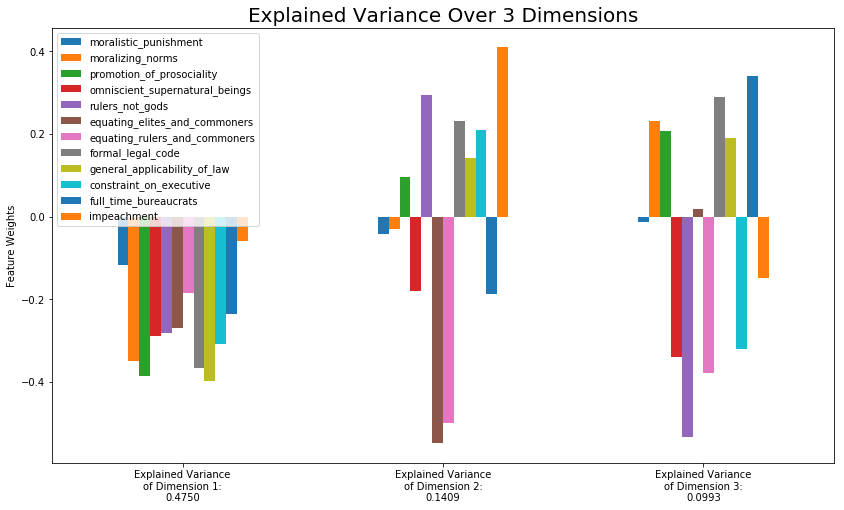

In [1310]:
# Run a PCA among features and plot the outcome.

### The code below is based loosely on code from Udacity's 
### Machine Learning nanodegree customer segmentation project at:
### https://github.com/udacity/machine-learning/tree/master/projects/customer_segments

# Run a PCA on the dataset.
pca = PCA(n_components = 3)
projected = pca.fit_transform(df)
# Index the dimensions and components.
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
components = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys())
components.index = dimensions
# Compute and index the variance ratios.
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4),
                               columns = ['explained variance'])
variance_ratios.index = dimensions
# Plot the PCA dimensions with a legend and explained variances.
fig, ax = plt.subplots(figsize = (14,8))
components.plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature Weights")
ax.legend(loc = 2)
ax.set_title("Explained Variance Over 3 Dimensions", fontsize = 20)
xlabels = []
for i, ev in enumerate(pca.explained_variance_ratio_):
    xlabels.append("Explained Variance\nof Dimension {}:\n{}".format(i+1,"%.4f" % ev))
ax.set_xticklabels(xlabels, rotation=0)

In [1311]:
# Print a PCA chart to examine the PCA dimensions in greater detail.
pd.concat([variance_ratios, components], axis = 1)

,explained variance,moralistic_punishment,moralizing_norms,promotion_of_prosociality,omniscient_supernatural_beings,rulers_not_gods,equating_elites_and_commoners,equating_rulers_and_commoners,formal_legal_code,general_applicability_of_law,constraint_on_executive,full_time_bureaucrats,impeachment
Dimension 1,0.4750,-0.1178,-0.3488,-0.3850,-0.2878,-0.2809,-0.2699,-0.1841,-0.3675,-0.3971,-0.3093,-0.2364,-0.0593
Dimension 2,0.1409,-0.0421,-0.0289,0.0950,-0.1797,0.2932,-0.5474,-0.4993,0.2326,0.1428,0.2105,-0.1865,0.4093
Dimension 3,0.0993,-0.0122,0.2312,0.2064,-0.3400,-0.5335,0.0174,-0.3782,0.2883,0.1905,-0.3208,0.3403,-0.1483


## Evaluation and Deployment
Although problematic in its subjectivity, brevity, differing timelines, and NaN values, Seshat's Axial Age dataset does demonstrate our ability to create new data about the past in order to draw new insights that can lead to new theories about the past, including the insights from question 2 that laws and prosociality tended to appear together while bureaucracies and social equality tend to appear separately from impeachment, or insights from question 3 that the Classic Greek and Confucian sociopolitical models might be thought of as independent dimensions along which Mediterranean and Asian socieities developed, sometimes simultanously and syncretically. The collaborative nature of the dataset's collection lends greater objective legitimacy, and can, and should, be replicated to create larger datasets around other historic topics for which we lack quatitative data.

As for this analysis, the findings gleaned from data *about* history, data that previously had not existed, can guide future research in directions previously underexplored. I welcome readers to validate or challenge the insights claimed in this article, and expand the boundaries of data science's applicability to the pre-information age.